<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%9B%94%EA%B0%84_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%98%88%EC%88%A0_%EC%9E%91%ED%92%88_%ED%99%94%EA%B0%80_%EB%B6%84%EB%A5%98_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

월간 데이콘 예술 작품 화가 분류 AI 경진대회 https://dacon.io/competitions/official/236006/overview/description

# module

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
!unzip -qq  '/content/drive/MyDrive/Colab Notebooks/데이콘/월간 데이콘 예술 작품 화가 분류/open.zip'

# EDA

In [ ]:
train = pd.read_csv('/content/train.csv', index_col='id')

In [ ]:
train.head()

,img_path,artist
id,,
0,./train/0000.jpg,Diego Velazquez
1,./train/0001.jpg,Vincent van Gogh
2,./train/0002.jpg,Claude Monet
3,./train/0003.jpg,Edgar Degas
4,./train/0004.jpg,Hieronymus Bosch


In [ ]:
train['img_path'] = sorted(glob.glob('/content/train/*'))

In [ ]:
def img_size(x):
    img = cv2.imread(x)
    return img.shape

train['img_shape'] = train['img_path'].apply(img_size)

KeyboardInterrupt: ignored

In [ ]:
def image_width(x):
    return x[1]
train['width'] = train['img_shape'].apply(image_width)

def image_height(x):
    return x[0]
train['height'] = train['img_shape'].apply(image_height)

In [ ]:
train.head()

,img_path,artist,img_shape,width,height
id,,,,,
0,/content/train/0000.jpg,Diego Velazquez,"(1300, 1024, 3)",1024,1300
1,/content/train/0001.jpg,Vincent van Gogh,"(1024, 568, 3)",568,1024
2,/content/train/0002.jpg,Claude Monet,"(722, 1024, 3)",1024,722
3,/content/train/0003.jpg,Edgar Degas,"(836, 1053, 3)",1053,836
4,/content/train/0004.jpg,Hieronymus Bosch,"(845, 782, 3)",782,845


In [ ]:
train['width'].max(), train['width'].min(), train['height'].max(), train['height'].min() 

(4096, 204, 3826, 226)

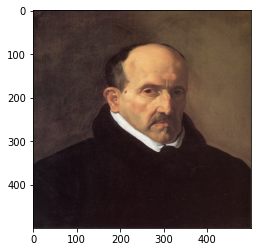

In [ ]:
img = cv2.cvtColor(cv2.imread(train.img_path[0]), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (500,500))
plt.imshow(img)

In [ ]:
transfomer = A.Compose([A.RandomCrop(250, 250)])

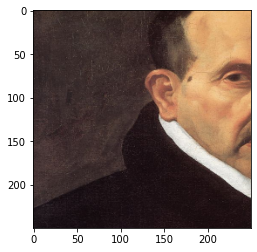

In [ ]:
image = transfomer(image=img)['image']
plt.imshow(image)

In [ ]:
artist_info = pd.read_csv('/content/artists_info.csv')
artist_info.head()

,name,years,genre,nationality
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican
3,Claude Monet,1840 - 1926,Impressionism,French
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian


In [ ]:
train.loc[3896]

,img_path,artist,img_shape,width,height
id,,,,,
3896,/content/train/3896.jpg,Edgar Degas,"(709, 1024, 3)",1024,709
3896,/content/train/3986.jpg,Titian,"(753, 1024, 3)",1024,753


In [ ]:
train.loc[train['img_path'] == '/content/train/3896.jpg', 'artist'] = 'Titian'
train.loc[train['img_path'] == '/content/train/3986.jpg', 'artist'] = 'Alfred Sisley'

In [ ]:
train.artist.nunique()

50

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


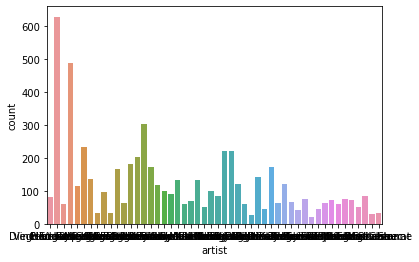

In [ ]:
sns.countplot(train.artist)
plt.show()

In [ ]:
train.to_csv('train_csv.csv', index=False)

# data_maker

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/월간 데이콘 예술 작품 화가 분류/train_csv.csv')

In [52]:
class data_maker(tf.keras.utils.Sequence):
    def __init__(self, path, label=None, img_size = 250, batch = 32, train = True, shuffle = False):
        self.path = path
        self.label = label
        self.img_size = img_size
        self.batch = batch
        self.train = train
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.path) / self.batch))

    def __getitem__(self, index):
        path_sel = self.path[index * self.batch : (index + 1) * self.batch]
        if self.label is not None:
            label_sel = self.label[index * self.batch : (index+1) * self.batch]
        
        transfomer = A.Compose([A.RandomCrop(self.img_size, self.img_size),
                                A.HorizontalFlip(),
                                A.RandomBrightnessContrast()])
        image = np.zeros((len(path_sel), self.img_size, self.img_size, 3), dtype=np.float32)
        for i in range(len(path_sel)):
            img = cv2.cvtColor(cv2.imread(path_sel[i]), cv2.COLOR_BGR2RGB)
            if self.train:
                img = cv2.resize(img, (500,500)) 
                img = transfomer(image=img)['image'] / 255
            else:
                img = cv2.resize(img, (self.img_size, self.img_size)) / 255

            image[i] = img

        if self.label is not None:
            return image, np.array(label_sel)
        else:
            return image

    def on_epoch_end(self):
        if self.shuffle:
            self.path, self.label = sklearn.utils.shuffle(self.path, self.label)
        else:
            pass

In [42]:
x_train = train['img_path']
y_train = pd.get_dummies(train['artist'])
classes = y_train.columns

x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)
x_ttrain.shape, x_ttest.shape, y_ttrain.shape, y_ttest.shape

((5319,), (592,), (5319, 50), (592, 50))

In [53]:
img_size = 250
train_ds = data_maker(x_ttrain.values, y_ttrain.values, img_size=img_size, batch=32, train=True, shuffle=True)
val_ds = data_maker(x_ttest.values, y_ttest.values, img_size=img_size, batch=32, train=True, shuffle=False)

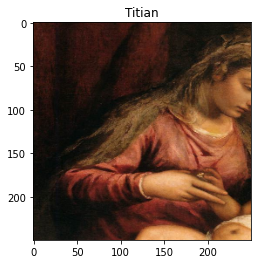

In [54]:
plt.imshow(train_ds[0][0][0])
plt.title(classes[np.argmax(train_ds[0][1][0])])
plt.show()

# traning

## make cnn

In [ ]:
def model_make1():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, 1, activation='relu')(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, 1, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, 1, activation='relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(50, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = model_make1()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 59, 59, 128)       7385

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
his = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
167/167 [==============================] - 437s 3s/step - loss: 3.6323 - accuracy: 0.1043 - val_loss: 3.4712 - val_accuracy: 0.1166
Epoch 2/20
167/167 [==============================] - 433s 3s/step - loss: 3.3988 - accuracy: 0.1491 - val_loss: 3.2777 - val_accuracy: 0.1689
Epoch 3/20
167/167 [==============================] - 429s 3s/step - loss: 3.2689 - accuracy: 0.1716 - val_loss: 3.2403 - val_accuracy: 0.1672
Epoch 4/20
167/167 [==============================] - 435s 3s/step - loss: 3.1389 - accuracy: 0.1863 - val_loss: 3.0536 - val_accuracy: 0.2027
Epoch 5/20
167/167 [==============================] - 434s 3s/step - loss: 3.0130 - accuracy: 0.2098 - val_loss: 2.9675 - val_accuracy: 0.1993
Epoch 6/20
 28/167 [====>.........................] - ETA: 5:46 - loss: 2.9676 - accuracy: 0.2087

KeyboardInterrupt: ignored

## efficientnet

In [ ]:
pre_layer = tf.keras.applications.efficientnet.preprocess_input
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
def model_make2():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = pre_layer(inputs)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(50, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = model_make2()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
early_stoper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stoper])

Epoch 1/50
167/167 [==============================] - 127s 705ms/step - loss: 3.6515 - accuracy: 0.1271 - val_loss: 3.1841 - val_accuracy: 0.3497
Epoch 2/50
167/167 [==============================] - 116s 692ms/step - loss: 2.9738 - accuracy: 0.3375 - val_loss: 3.0827 - val_accuracy: 0.2922
Epoch 3/50
167/167 [==============================] - 114s 683ms/step - loss: 2.5212 - accuracy: 0.4279 - val_loss: 2.5652 - val_accuracy: 0.4189
Epoch 4/50
167/167 [==============================] - 114s 679ms/step - loss: 2.2287 - accuracy: 0.4860 - val_loss: 2.2193 - val_accuracy: 0.4510
Epoch 5/50
167/167 [==============================] - 115s 684ms/step - loss: 2.0236 - accuracy: 0.5196 - val_loss: 2.1646 - val_accuracy: 0.4730
Epoch 6/50
167/167 [==============================] - 115s 686ms/step - loss: 1.8658 - accuracy: 0.5582 - val_loss: 1.7087 - val_accuracy: 0.5760
Epoch 7/50
167/167 [==============================] - 115s 688ms/step - loss: 1.7647 - accuracy: 0.5666 - val_loss: 2.0021 -

In [ ]:
model.save('model_eff.h5')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stoper])

Epoch 1/50
167/167 [==============================] - 128s 711ms/step - loss: 1.2035 - accuracy: 0.6789 - val_loss: 1.2469 - val_accuracy: 0.6943
Epoch 2/50
167/167 [==============================] - 115s 687ms/step - loss: 1.1980 - accuracy: 0.6691 - val_loss: 1.3550 - val_accuracy: 0.6419
Epoch 3/50
167/167 [==============================] - 115s 686ms/step - loss: 1.1882 - accuracy: 0.6774 - val_loss: 1.2749 - val_accuracy: 0.6740


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stoper])

Epoch 1/50
167/167 [==============================] - 129s 713ms/step - loss: 1.1770 - accuracy: 0.6783 - val_loss: 1.1701 - val_accuracy: 0.6909
Epoch 2/50
167/167 [==============================] - 115s 688ms/step - loss: 1.1578 - accuracy: 0.6798 - val_loss: 1.1674 - val_accuracy: 0.6892
Epoch 3/50
167/167 [==============================] - 115s 686ms/step - loss: 1.1717 - accuracy: 0.6789 - val_loss: 1.2150 - val_accuracy: 0.6824
Epoch 4/50
167/167 [==============================] - 115s 687ms/step - loss: 1.1434 - accuracy: 0.6936 - val_loss: 1.2034 - val_accuracy: 0.6723


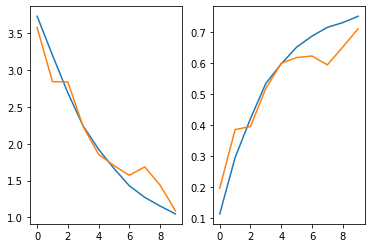

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

## efficientnetv2

In [ ]:
pre_layer = tf.keras.applications.efficientnet_v2.preprocess_input
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True

24289280/24274472 [==============================] - 0s 0us/step


In [ ]:
def model_make2_1():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = pre_layer(inputs)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(50, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = model_make2_1()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1024)              1311744   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               5248

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
early_stoper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stoper])

Epoch 1/50
167/167 [==============================] - 174s 649ms/step - loss: 3.8552 - accuracy: 0.0519 - val_loss: 3.7725 - val_accuracy: 0.1267
Epoch 2/50
167/167 [==============================] - 105s 630ms/step - loss: 3.7102 - accuracy: 0.1203 - val_loss: 3.6335 - val_accuracy: 0.1672
Epoch 3/50
167/167 [==============================] - 104s 621ms/step - loss: 3.5569 - accuracy: 0.1504 - val_loss: 3.4774 - val_accuracy: 0.1757
Epoch 4/50
167/167 [==============================] - 106s 634ms/step - loss: 3.4056 - accuracy: 0.1664 - val_loss: 3.3432 - val_accuracy: 0.1807
Epoch 5/50
167/167 [==============================] - 106s 634ms/step - loss: 3.2845 - accuracy: 0.1810 - val_loss: 3.2110 - val_accuracy: 0.1943
Epoch 6/50
167/167 [==============================] - 105s 629ms/step - loss: 3.1916 - accuracy: 0.1991 - val_loss: 3.1167 - val_accuracy: 0.1993
Epoch 7/50
167/167 [==============================] - 106s 633ms/step - loss: 3.1153 - accuracy: 0.2134 - val_loss: 3.0311 -

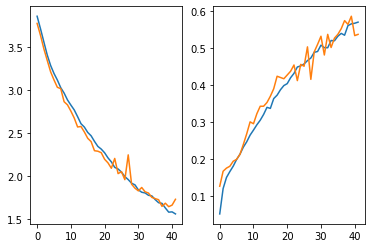

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

## xeption

In [7]:
pre_layer = tf.keras.applications.xception.preprocess_input
base_model = tf.keras.applications.Xception(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True

83697664/83683744 [==============================] - 0s 0us/step


In [18]:
def model_make3():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = pre_layer(inputs)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(50, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [55]:
model = model_make3()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
early_stoper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stoper])

Epoch 1/50
167/167 [==============================] - 154s 869ms/step - loss: 3.7756 - accuracy: 0.0886 - val_loss: 3.8481 - val_accuracy: 0.1047
Epoch 2/50
167/167 [==============================] - 141s 843ms/step - loss: 3.5424 - accuracy: 0.1280 - val_loss: 3.7353 - val_accuracy: 0.1318
Epoch 3/50
167/167 [==============================] - 140s 838ms/step - loss: 3.3863 - accuracy: 0.1630 - val_loss: 3.3894 - val_accuracy: 0.1976
Epoch 4/50
167/167 [==============================] - 141s 843ms/step - loss: 3.2422 - accuracy: 0.1995 - val_loss: 3.1753 - val_accuracy: 0.2247
Epoch 5/50
167/167 [==============================] - 141s 842ms/step - loss: 3.0737 - accuracy: 0.2427 - val_loss: 2.9224 - val_accuracy: 0.2889
Epoch 6/50
167/167 [==============================] - 140s 839ms/step - loss: 2.9144 - accuracy: 0.2792 - val_loss: 2.7249 - val_accuracy: 0.3226
Epoch 7/50
167/167 [==============================] - 141s 841ms/step - loss: 2.7371 - accuracy: 0.3205 - val_loss: 2.6156 -

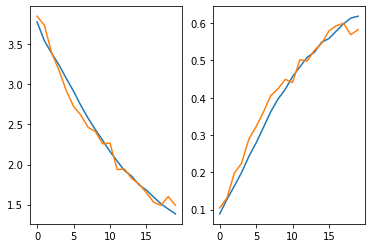

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
early_stoper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=1, verbose=1, min_lr=0.000005)

In [36]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stoper, LR])

Epoch 1/50
167/167 [==============================] - 148s 855ms/step - loss: 2.7052 - accuracy: 0.4463 - val_loss: 2.9595 - val_accuracy: 0.3260 - lr: 2.0000e-05
Epoch 2/50
167/167 [==============================] - 141s 842ms/step - loss: 1.4265 - accuracy: 0.7090 - val_loss: 2.3957 - val_accuracy: 0.4240 - lr: 2.0000e-05
Epoch 3/50
167/167 [==============================] - 142s 848ms/step - loss: 1.0189 - accuracy: 0.7667 - val_loss: 1.5157 - val_accuracy: 0.6318 - lr: 2.0000e-05
Epoch 4/50
167/167 [==============================] - ETA: 0s - loss: 0.8466 - accuracy: 0.7960
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
167/167 [==============================] - 141s 842ms/step - loss: 0.8466 - accuracy: 0.7960 - val_loss: 1.8426 - val_accuracy: 0.5777 - lr: 2.0000e-05
Epoch 5/50
167/167 [==============================] - 142s 847ms/step - loss: 0.7528 - accuracy: 0.8126 - val_loss: 1.0668 - val_accuracy: 0.7213 - lr: 1.0000e-05
Epoch 6/50
167/167 [====

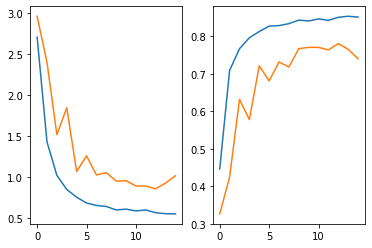

In [37]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
early_stoper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=1, verbose=1, min_lr=0.0000005)

In [57]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stoper, LR])

Epoch 1/50
167/167 [==============================] - 148s 855ms/step - loss: 2.9183 - accuracy: 0.3845 - val_loss: 2.7885 - val_accuracy: 0.3784 - lr: 2.0000e-05
Epoch 2/50
167/167 [==============================] - 140s 836ms/step - loss: 1.6344 - accuracy: 0.6591 - val_loss: 1.5177 - val_accuracy: 0.6385 - lr: 2.0000e-05
Epoch 3/50
167/167 [==============================] - 141s 842ms/step - loss: 1.2377 - accuracy: 0.7187 - val_loss: 1.2862 - val_accuracy: 0.6706 - lr: 2.0000e-05
Epoch 4/50
167/167 [==============================] - 141s 841ms/step - loss: 1.0309 - accuracy: 0.7473 - val_loss: 1.2319 - val_accuracy: 0.7010 - lr: 2.0000e-05
Epoch 5/50
167/167 [==============================] - 140s 838ms/step - loss: 0.9378 - accuracy: 0.7663 - val_loss: 1.0420 - val_accuracy: 0.7247 - lr: 2.0000e-05
Epoch 6/50
167/167 [==============================] - ETA: 0s - loss: 0.8707 - accuracy: 0.7708
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
167/167 [====

# sub

In [58]:
submission = pd.read_csv('/content/sample_submission.csv')

In [59]:
test_path = sorted(glob.glob('/content/test/*'))
test_ds = data_maker(test_path, img_size=img_size, batch=32, train=False, shuffle=False)
pre = classes[np.argmax(model.predict(test_ds), axis=1)]

In [60]:
submission['artist'] = pre
submission.to_csv('sub.csv', index=False)